# Handwritten Character Recognition: Using Machine Learning to Detect a 'W' in the demographic column

This notebook builds upon the image processing work in the document segmentation notebook. The code from that notebook has been consolidated into a file called 'segmentation.py' and will be imported for use in this notebook. This notebook will demonstrate a machine learning approach to recognizing handwritten characters, using a layered *neural network* that is trained on the publically available EMNIST letters dataset. The E in EMNIST stands for Extended, as it is an extended version of the MNIST dataset, which is the Modified National Institute of Standards and Technology (NIST) dataset of handwritten digits. Before you can train a machine learning model (or neural network) on the digit dataset you have to download it from the NIST website. Lucky for us, the Keras toolkit now includes functions that automate the download of the dataset the first time that you use it. Be forewarned that this code will take a long time to execute the first time, depending upon your network speed.

This notebook is partially based on the [Keras MNIST tutorial](https://colab.research.google.com/github/AviatorMoser/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb) written by Daniel Moser (UT Southwestern Medical Center). We modify their approach to focus on letters exclusively and explore training a NN and Convolutional NN (CNN) to specialize in recognizing the W character alone.

## Install Dependencies
The first step is to install some necessary Python libraries for machine learning. We are using the Google suite of tools, which include *TensorFlow* and *Keras*, which is a somewhat simpler API that wraps the base functions provided by TensorFlow. Please Note: There is a strange situation with Keras version 3 that requires it to be installed (or reinstalled) after you install tensorflow. (TensorFlow tries to install it's own earlier version of Keras.)

Be sure to restart your kernel after these tools have installed.

In [12]:
%pip install --upgrade tensorflow numpy tensorflow-datasets
%pip install --upgrade keras=="3"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 11.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.1
    Uninstalling tensorflow-2.15.1:
      Successfully uninstalled tensorflow-2.15.1
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 3.6 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: keras
    Found existing installation: keras 3.2.0
    Uni

## Loading the EMNIST image data into a TensorFlow Dataset

The next step is to setup the tensorflow training dataset that contains the digits that we want to use to train a model. EMNIST includes thousands of grayscale images that are 28x28 pixels in size with 256 levels of gray. The images are numerically labelled with the letter represented in the image. For instance, a 'W' is labelled with the number 23. The following code uses the TensorFlow Datasets module to load our chosen dataset. It will download the data the first time that you run it, which can take some time. Notice that we have specified some options to the `load()` function, saying that we desire only letters. It also specifies that we want the dataset split into  both training data and testing data. The testing data will be used to measure the accuracy of our model after training. We also load information about the dataset into a separate Python dictionary.

First we print out the dataset info object, then we display a grid of the first 9 images in the dataset, so that you can see what the images look like.

/home/jansen/.local/share/virtualenvs/census-form-image-processing-VTyG8Y6d/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-10 11:58:35.749467: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 11:58:35.750388: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 11:58:35.792362: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 11:58:35.922225: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is o

tfds.core.DatasetInfo(
    name='emnist',
    full_name='emnist/letters/3.0.0',
    description="""
    The EMNIST dataset is a set of handwritten character digits derived from the NIST Special Database 19 and converted to a 28x28 pixel image format and dataset structure that directly matches the MNIST dataset.
    
    Note: Like the original EMNIST data, images provided here are inverted horizontally and rotated 90 anti-clockwise. You can use `tf.transpose` within `ds.map` to convert the images to a human-friendlier format.
    """,
    config_description="""
    EMNIST Letters
    """,
    homepage='https://www.nist.gov/itl/products-and-services/emnist-dataset',
    data_dir='/home/jansen/tensorflow_datasets/emnist/letters/3.0.0',
    file_format=tfrecord,
    download_size=535.73 MiB,
    dataset_size=44.14 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
    }),
    supervis

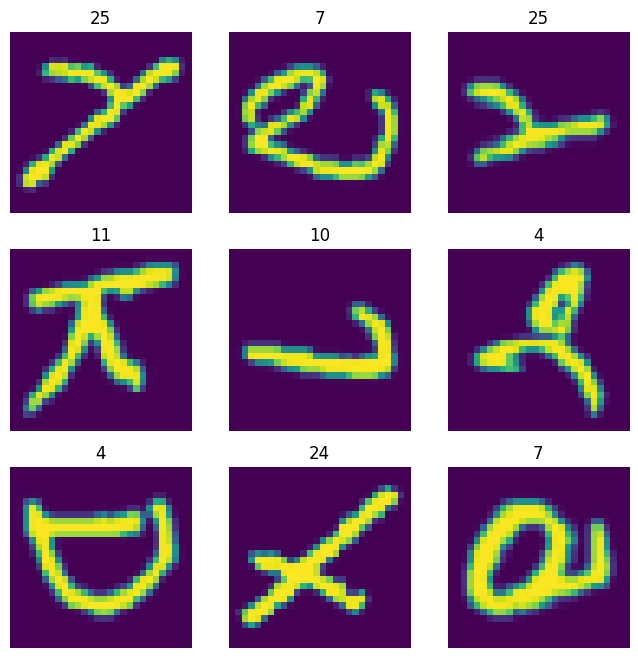

In [1]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines

#from tensorflow.keras.utils import to_categorical              # NumPy related tools

# Data should be located in a folder called EMNIST
import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print(ds_info)

plt.figure(figsize=(8, 8))
for i, (img, lbl) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(str(int(lbl)))
    plt.axis("off")

You may notice that the letters look pretty strange. They are in fact inverted horizontally and rotated 90 degrees anti-clockwise. This is a legacy of the original EMNIST dataset and is maintained in the tensorflow version for consistency. You can read this explanation in the dataset information we printed above. There are also instructions there for how to make the images match our expectations and we will follow those in steps below.

**Please Note:**  The number of classes (labels) for the images is listed as 37 in the dataset information dictionary. This is in fact a typo in the TensorFlow dataset, as of 3.0 version still there. The same typo occurs in the original EMNIST paper, where the number of classes in the "letters" subset is reported as both 37 AND 26 in different places. I discovered this discrepancy towards the end of my analysis. We can simply treat the number of classes as 26 and ignore the incorrect 37.

## Census Data

Let's load and preview some census demographic code images for comparison. Remember that we are training a model to recognize the census W's based entirely on these EMNIST examples. The two data sources do not resemble each other much yet, but we can take steps to bring them closer together.

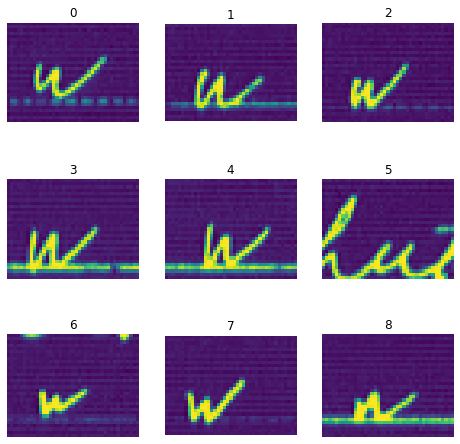

In [2]:
# First we load the segmentation code that we developed in that notebook
with open("segmentation.py") as f:
    code = f.read()
exec(code)

page = "pages/43290879-California-101393-0002.jpeg"
cells = list(generateCellImages(page))
plt.figure(figsize=(8, 8))
for i, image in enumerate(cells[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(str(i))
    plt.axis("off")


If you compare the Census 'W' images to the EMNIST letters, you should notice a few things:

* The EMNIST images are 28 by 28 pixels square, whereas the Census cell images are taller and wider.
* The EMNIST images are rotated and flipped, whereas the Census cell images are oriented normally.
* The Census images contain some extraneous ink, usually a horizontal rule that marks the botton of the demographic cell. This noisy line is sometimes faint and sometimes heavy. The EMNIST image consist of clear and crisp letters with no extraneous ink.

To make the machine learning approach work best, we will adjust our data to correct these differences. First let's pick the best 28 by 28 pixel square from the Census cells. We define a function *crop_cell()* to do this work for us. We ideally want to center the square on the W character, or whatever is written within the cell. To approximate that we'll find the "center of ink" within the cell and make that point, call the moment, the center of our square. If the center of mass is too close to an edge we'll adjust the crop so that the square aligns with that edge.

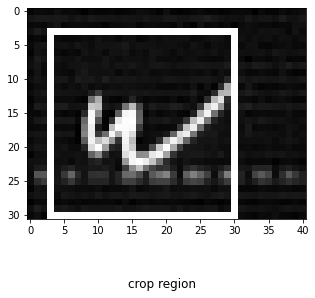

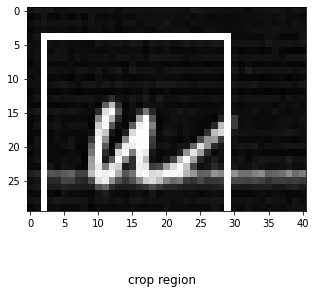

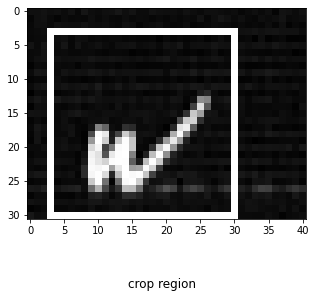

In [3]:
def crop_cell(cell_img, debug=False):
    M = cv2.moments(cell_img)
    X = int(M["m10"] / M["m00"])
    Y = int(M["m01"] / M["m00"])
    x1 = min(max(0, X-13), cell_img.shape[0] - 28)
    y1 = min(max(0, Y-13), cell_img.shape[1] - 28)
    cell = cell_img[x1:x1+28, y1:y1+28]
    cv2.rectangle(cell_img, (x1, y1, 28, 28), RED, thickness=1)
    view(cell_img, "crop region")    
    return cell

page = "pages/43290879-California-101393-0002.jpeg"
cells = list(generateCellImages(page))
for image in cells[:3]:
    crop_cell(image, debug=True)



## Transpose ENMIST Letters to a Readable Orientation

Now that we have a 28x28 square census image, let's make sure that we unrotate and unflip the EMNIST images so that they look like the normal readable letters from the Census. In order to do that we are going to use a TensorFlow *map()* operation to apply the same function, in a streaming fashion as needed, to every image in the training and testing sets. The function we will apply to every image is the TensorFlow *transpose()* function, which is the one recommended in the dataset notes. You can see that our preview grid is now readable.

2024-04-10 11:59:13.735427: E tensorflow/core/util/util.cc:131] oneDNN supports DT_UINT8 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2024-04-10 11:59:13.785551: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-10 11:59:13.790351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


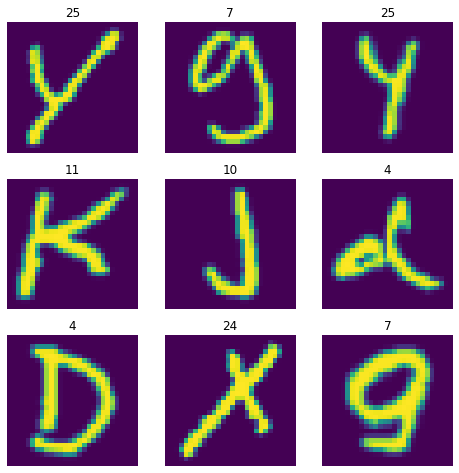

In [4]:
import tensorflow as tf

import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

ds_train_readable = ds_train.map(
  lambda img, label: (tf.transpose(img, perm=[1,0,2]), label),
  num_parallel_calls=tf.data.AUTOTUNE, 
  deterministic=True)

plt.figure(figsize=(8, 8))
for i, (img, lbl) in enumerate(ds_train_readable.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(str(int(lbl)))
    plt.axis("off")

## Adding Noise to Match Census Data

Okay, we're almost ready. Now we have to account for the additional noisy ink in the Census images. This ink is pretty hard to remove from around each character in the Census images. Instead of removing ink from the Census images, we are going to try adding similar ink to the training and testing data from EMNIST. This seems counterintuitive to us because we associate letters with concepts and their particular shapes. To a machine learning model these letters are simply patterns of pixels. We'll train a model to recognize letters with noisy lines added to them and this will be easier that removing those lines using computer vision techniques.

We use the same *map()* operation to add noise to the EMNIST images. One thing to note here is that while we are dealing with 28x28 pixel images, the TensorFlow datasets are provided as matrices with three dimensions. This is because the images are provided as batches, with multiple images provided in one larger matrix. Hence the functions we are mapping below have to deal in three dimensional inputs and outputs.

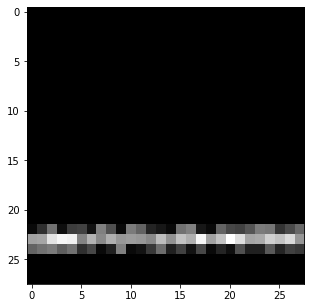

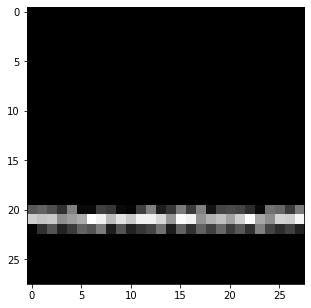

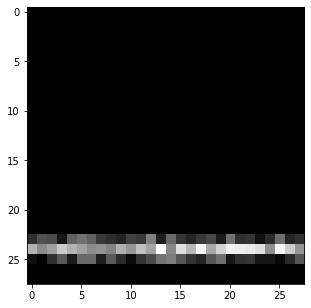

2024-04-11 10:20:16.882190: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-04-11 10:20:16.887358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


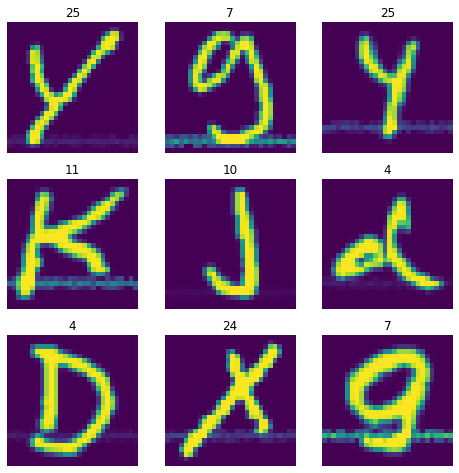

In [36]:

# This function is used to add two matrices together without exceeding the pixel value of 255.
def add_to_255(a, b):
    """Return a+b to a max value of 255"""
    if a + b > 255:
        return 255
    else:
        return a + b
v_add_to_255 = np.vectorize(add_to_255)  # Here we create a "vectorized" form of our simple function above.

def noisy_line(img, label):
    """Adds background noise and a vertical line on the right edge to match data"""
    rng = np.random.default_rng()  # This function uses a random number generator, created here.
    line = np.zeros((28,28,1), dtype=np.uint8)  # Our line will be defined in a 28x28 matrix, initial set to zeroes.
    
    # We pick a random number c, from 20 to 25, as the center position of our horizontal line.
    c = rng.integers(20, high=25, size=1)[0]  # randomized position of line
    a = rng.integers(0, high=100, size=1)[0]  # randomized transparency of line

    # We set the center of the line to a max of 200 and adjacent rows to a max of 100.
    line[c,:] = (100 - a)
    line[c+1,:] = (200 - 2 * a)
    line[c+2,:] = (100 - a)
    noise = rng.integers(0, high=(100-a),size=(3,28,1))
    line[c:c+3,:] = line[c:c+3,:] - noise
    img = v_add_to_255(img, line)
    return img, label

# Some examples of the noise we will add to EMNIST
z = np.zeros((28,28, 1), dtype=np.uint8)
view(noisy_line(z, 0)[0])  # The views show normalized luminence, i.e. they treat the highest value found as white.
view(noisy_line(z, 1)[0])  # This means that our transparency value has no impact in these previews of the noisy lines.
view(noisy_line(z, 2)[0])

# Some examples of EMNIST letters with noise added.
plt.figure(figsize=(8, 8))
for i, (image, label) in enumerate(ds_train_readable.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    #img_numpy = image.numpy()[..., None]  # Adding a dimension to match TF dataset API
    img_numpy = image.numpy()  # Adding a dimension to match TF dataset API
    img, lbl = noisy_line(img_numpy, label.numpy())
    plt.imshow(img)
    plt.title(str(int(lbl)))
    plt.axis("off")


These images with noisy horizontal lines are a better match for the Census data. We expect that any model trained to recognize these letters will also recognize 'W' characters from the Census data.

# Applying Functions (Mapping) and Normalizing to Floating Point Values

We have shown some examples of the transformations that we need, both to the Census images and to the EMNIST letters training and testing data. Now we will apply those tranformation to the EMNIST training and testing data. Each transformation is applied in a series of steps using the *map()* function.

In [40]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

print("initial element spec", ds_train.element_spec)

ds_train_readable = ds_train.map(
  lambda img, label: (tf.transpose(img, perm=[1,0,2]), label),
  num_parallel_calls=tf.data.AUTOTUNE, 
  deterministic=True)

# Mapping the noisy line function to the dataset..
ds_train_readable_noisy = ds_train_readable.map(
  lambda img, label: tf.numpy_function(func=noisy_line, inp=[img, label], Tout=(tf.uint8, tf.int64)),
  num_parallel_calls=tf.data.AUTOTUNE, 
  deterministic=False)

# Function to convert image pixel values to floating point between 0 and 1.
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# Mapping the normalize function to the dataset
ds_train_readable_noisy_float = ds_train_readable_noisy.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

def set_shapes(image, label):
  image.set_shape([28, 28, 1])
  label.set_shape([])
  return image, label

# Assert the correct tensor shapes
ds_train_final = ds_train_readable_noisy_float.map(set_shapes, num_parallel_calls=tf.data.AUTOTUNE)

# Some additional dataset setup steps
ds_train_final = ds_train_final.cache()
ds_train_final = ds_train_final.batch(128)  # This changes the shape of the data, so call it after all mapped functions..
ds_train_final = ds_train_final.prefetch(tf.data.AUTOTUNE)
print("final element_spec", ds_train_final.element_spec)

# Then we need to apply the same functions and settings to the test dataset
ds_test_readable = ds_test.map(
  lambda img, label: (tf.transpose(img, perm=[1,0,2]), label),
  num_parallel_calls=tf.data.AUTOTUNE, 
  deterministic=True)

ds_test_readable_noisy = ds_test_readable.map(
  lambda img, label: tf.numpy_function(func=noisy_line, inp=[img, label], Tout=(tf.uint8, tf.int64)),
  num_parallel_calls=tf.data.AUTOTUNE, 
  deterministic=False)
ds_test_readable_noisy_float = ds_test_readable_noisy.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_final = ds_test_readable_noisy_float.map(set_shapes, num_parallel_calls=tf.data.AUTOTUNE)
ds_test_final = ds_test_final.batch(128)
ds_test_final = ds_test_final.cache()
ds_test_final = ds_test_final.prefetch(tf.data.AUTOTUNE)
print("final test element_spec", ds_test_final.element_spec)

initial element spec (TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
final element_spec (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))
final test element_spec (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))


In [50]:
model = tf.keras.models.Sequential([
  tf.keras.Input(shape=(28,28), name='input'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(27)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.summary()

model.fit(
    ds_train_final,
    epochs=15,
    validation_data=ds_test_final,
)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 128)               │    100,480 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 27)                │      3,483 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 103,963 (406.11 KB)

 Trainable params: 103,963 (406.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.4878 - sparse_categorical_accuracy: 0.5881 - val_loss: 0.7845 - val_sparse_categorical_accuracy: 0.7720
Epoch 2/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6915 - sparse_categorical_accuracy: 0.8001 - val_loss: 0.6073 - val_sparse_categorical_accuracy: 0.8189
Epoch 3/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5315 - sparse_categorical_accuracy: 0.8435 - val_loss: 0.5338 - val_sparse_categorical_accuracy: 0.8382
Epoch 4/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4542 - sparse_categorical_accuracy: 0.8647 - val_loss: 0.4951 - val_sparse_categorical_accuracy: 0.8486
Epoch 5/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4067 - sparse_categorical_accuracy: 0.8766 - val_loss: 0.4744 - val_sparse_categorical_accuracy: 0.8535
Epoch 6/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3725 - sparse_categorical_accuracy: 0.8857 - val_loss: 0.4623 - val_sparse_categorical_accuracy: 0.8552
Epoch 7/15
694/

pages/43290879-California-101393-0014.jpeg


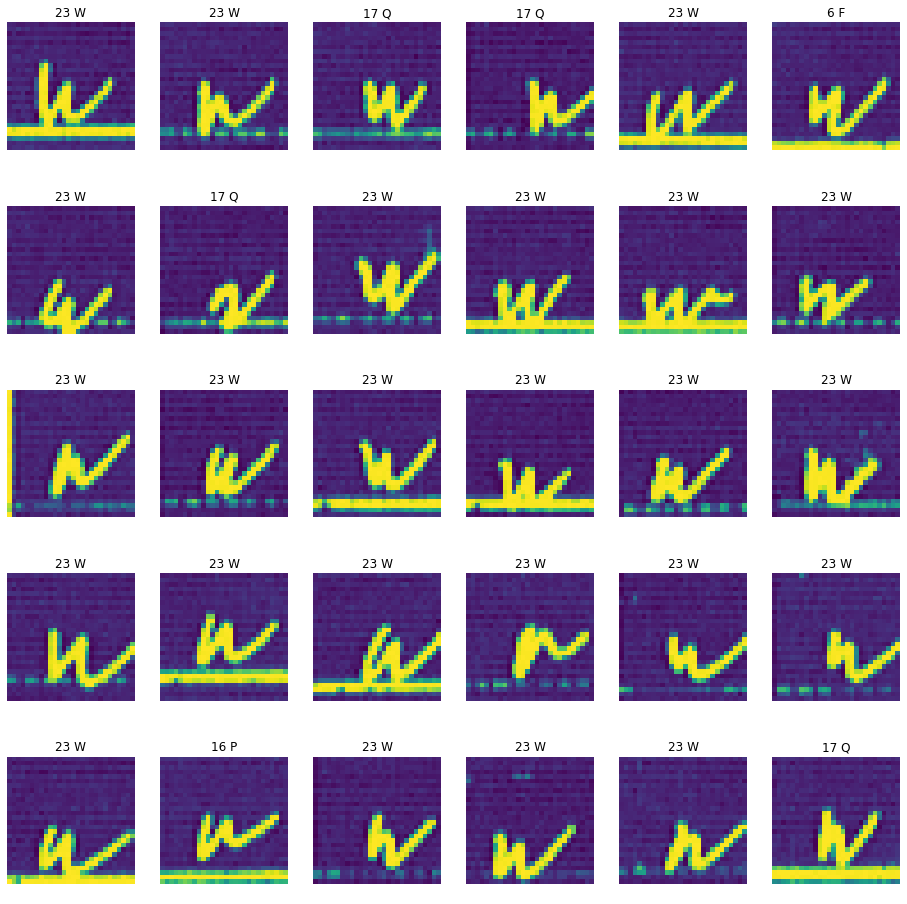

pages/43290879-California-101393-0015.jpeg


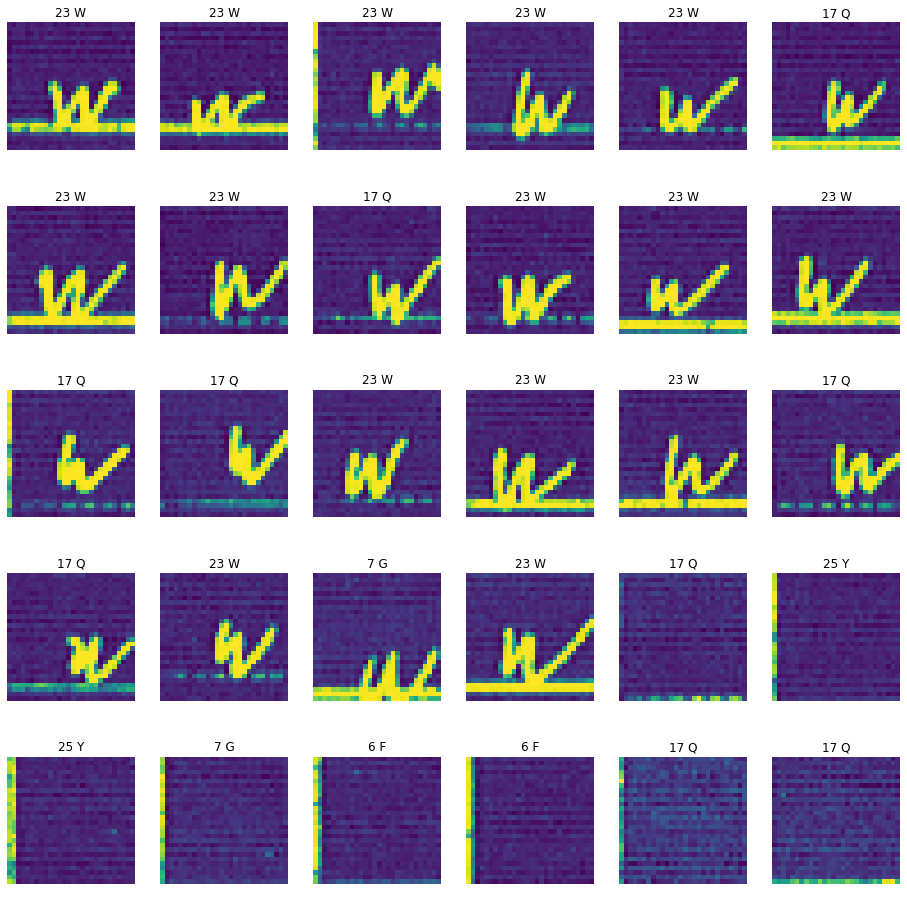

pages/43290879-California-101393-0016.jpeg


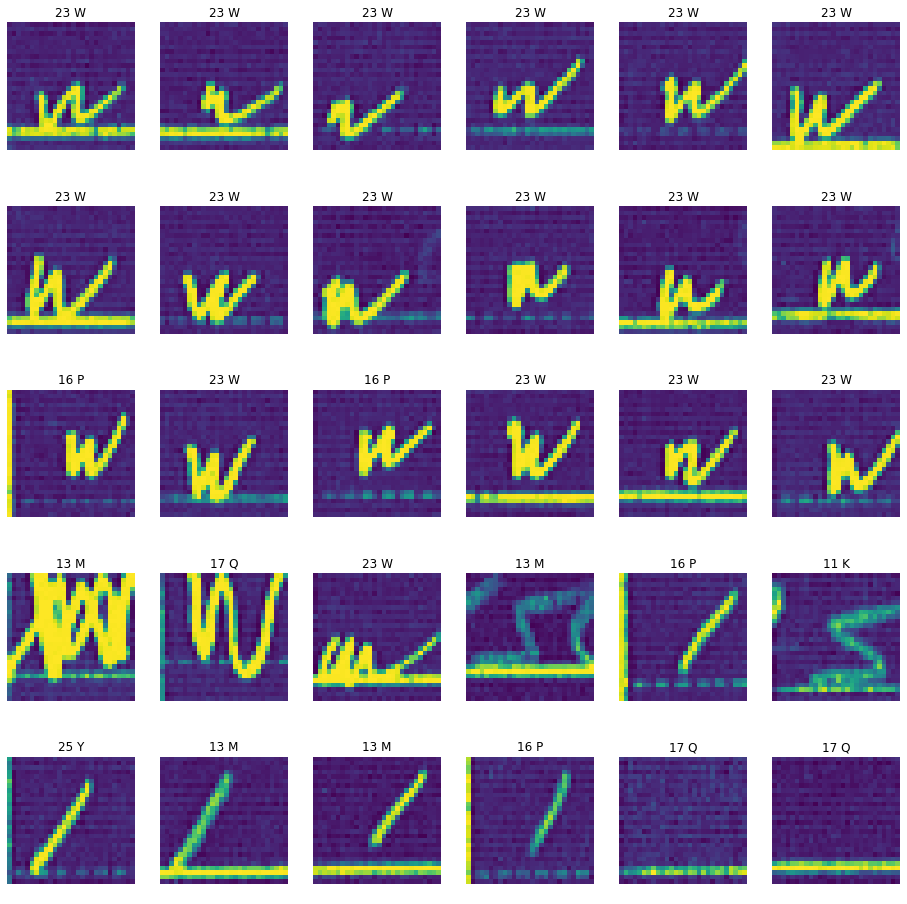

In [69]:
import glob
import re
import cv2

lookup = list("abcdefghijklmnopqrstuvwxyz".upper())

def run(path, page_range=(2, 16), model=None, debug=False):
    for f in sorted(glob.glob(f'{path}/*')):
        pagestr = re.search(r'-(\d+).jpeg', f).group(1)
        if int(pagestr) not in range(page_range[0], page_range[1]):
            continue
        plt.figure(figsize=(16, 16))
        plt.axis("off")
        print(f)
        image = cv2.imread(f)
        (adjusted_img, v_lines, h_lines) = extract(image, f, debug=debug)
        grayimage = cv2.cvtColor(adjusted_img,cv2.COLOR_BGR2GRAY)
        grayimage = 255 - grayimage
        #grayimage = cv2.threshold(grayimage, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
        demo_h_offset = v_lines[11]  # the demographic column starts the the 12th vertical line
        demo_width = v_lines[12] - demo_h_offset  # width calculation
        # Open CV rectangles calculation for each demographic cell
        demographic_cells = \
          [ (demo_h_offset, h_lines[i], demo_width, int(h_lines[i+1]-h_lines[i])) for i in range(3, len(h_lines)-1)]
        for i in range(3, len(h_lines)-1):
            ax = plt.subplot(5, 6, i - 2)
            plt.axis('off')
            cell_img = grayimage[h_lines[i]+5:h_lines[i+1]+5, v_lines[11]:v_lines[12]]
            M = cv2.moments(cell_img)
            X = int(M["m10"] / M["m00"])
            Y = int(M["m01"] / M["m00"])
            x1 = min(max(0, X-13), cell_img.shape[0] - 28)
            y1 = min(max(0, Y-13), cell_img.shape[1] - 28)
            cell = cell_img[x1:x1+28, y1:y1+28]
            tensor, noop = normalize_img(cell, 0)  # Note the transpose to match training set.
            result = model.predict(np.expand_dims(tensor, 0), verbose=0)
            classes_x=np.argmax(result,axis=1)
            plt.imshow(cell)
            plt.title(f'{classes_x[0]} {lookup[int(classes_x[0])-1]}')
        plt.show()


run('pages', page_range=(14,17), model=model)

In [ ]:
conv_model = tf.keras.models.Sequential(
  [
    tf.keras.Input(shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(27, activation="softmax"),
  ] 
)

conv_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

conv_model.summary()

conv_model.fit(
    ds_train_final,
    epochs=15,
    validation_data=ds_test_final,
)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)        │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_6 (Flatten)             │ (None, 1600)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 1600)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 27)                │     43,227 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 62,043 (242.36 KB)

 Trainable params: 62,043 (242.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


694/694 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.4244 - sparse_categorical_accuracy: 0.5795 - val_loss: 0.4923 - val_sparse_categorical_accuracy: 0.8439
Epoch 2/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.5127 - sparse_categorical_accuracy: 0.8383 - val_loss: 0.3925 - val_sparse_categorical_accuracy: 0.8758
Epoch 3/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4189 - sparse_categorical_accuracy: 0.8690 - val_loss: 0.3510 - val_sparse_categorical_accuracy: 0.8884
Epoch 4/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3769 - sparse_categorical_accuracy: 0.8800 - val_loss: 0.3214 - val_sparse_categorical_accuracy: 0.8980
Epoch 5/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3443 - sparse_categorical_accuracy: 0.8896 - val_loss: 0.3084 - val_sparse_categorical_accuracy: 0.9022
Epoch 6/15
694/694 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3222 - sparse_categorical_accuracy: 0.8963 - val_loss: 0.2967 - val_sparse_categorical_accuracy: 0.9046
Epoch 7/15
694/

pages/43290879-California-101393-0014.jpeg


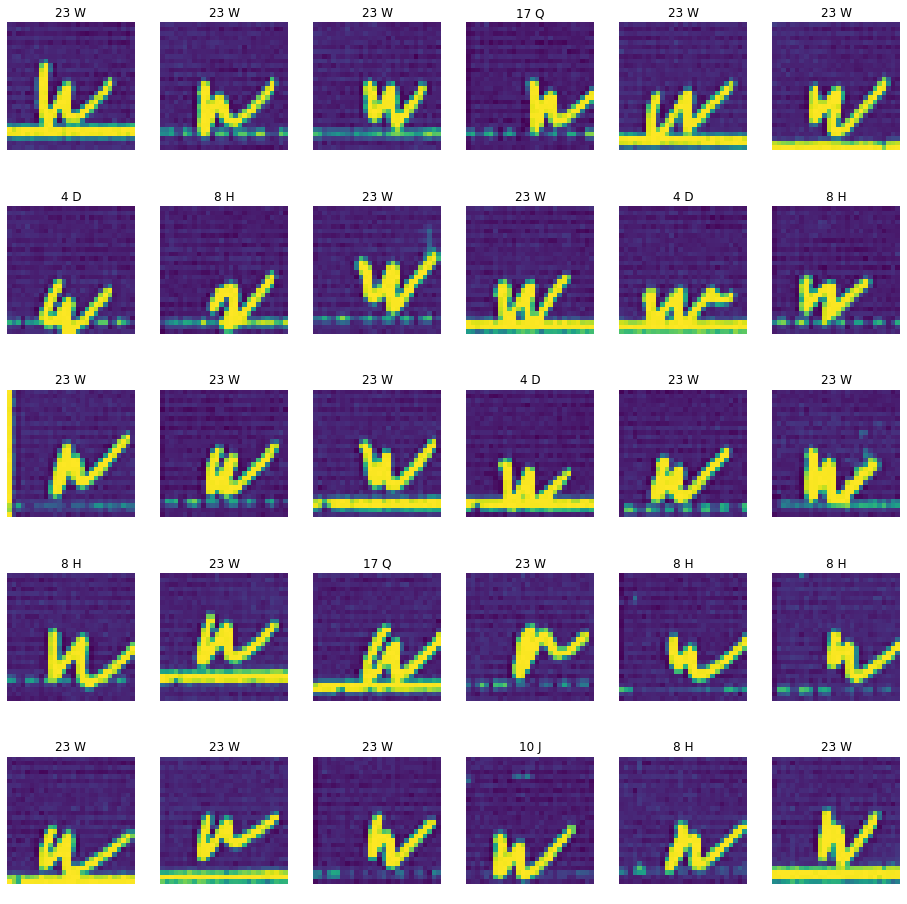

pages/43290879-California-101393-0015.jpeg


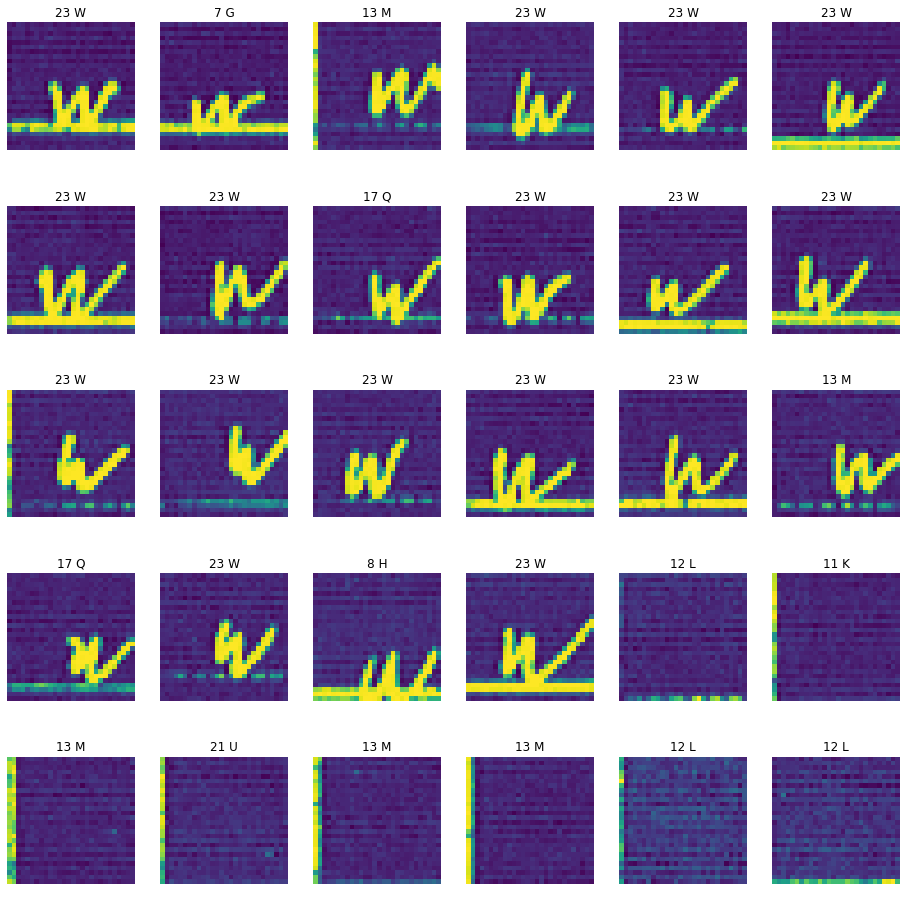

pages/43290879-California-101393-0016.jpeg


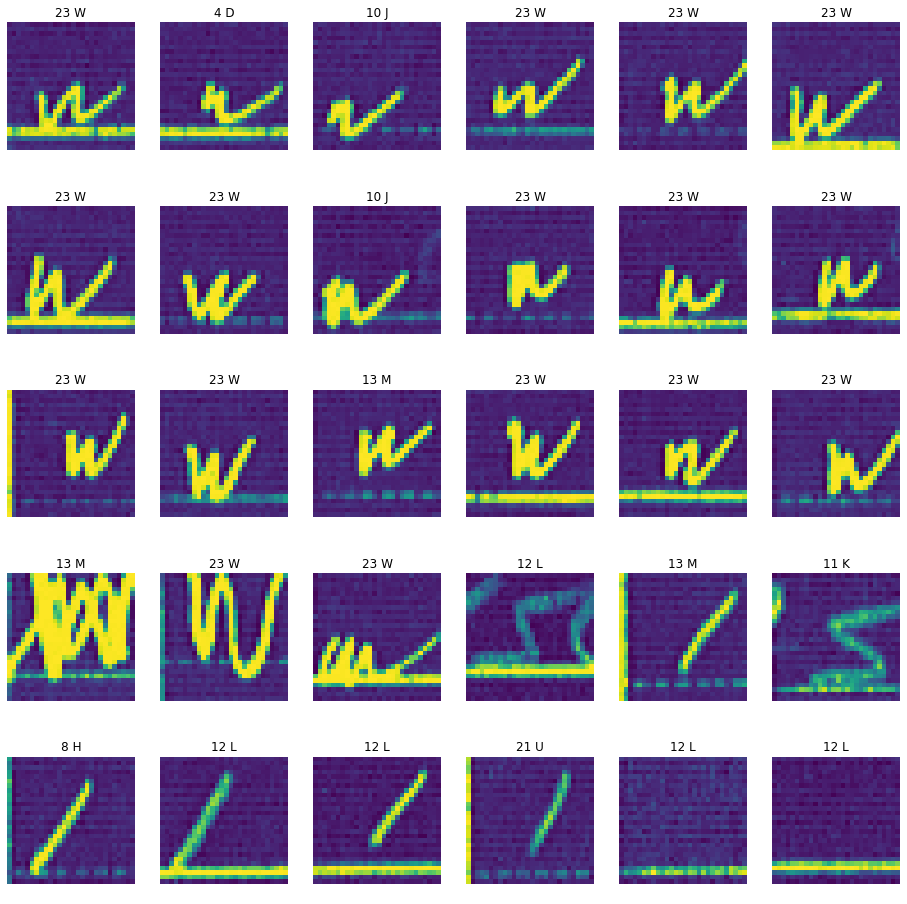

In [70]:
run('pages', page_range=(14,17), model=conv_model)